# 1. Set up

# 2. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 3. Define global variables

In [2]:
n_contadores = 10000

# 4. Functions

In [3]:
# Simulación de energía: importada, exportada, reactiva (niveles 1 a 4), en distintas ventanas temporales
def sim_energia(base, scale=1000):
    return np.random.normal(loc=base, scale=scale * 0.1, size=n_contadores).clip(0, None)

# 5. Code

In [4]:
tipologia_cliente = ['particular', 'empresa', 'administración pública']
tipo_consumo = ['gas', 'energia']
ubicaciones = [f'loc_{i}' for i in range(1, 21)]

We simulate data in order to construct or create the master table where we will extract those desired anomalies

In [5]:
np.random.seed(42)

In [6]:
df = pd.DataFrame({
    'contador': [f'C_{i:05d}' for i in range(n_contadores)],
    'cliente': [f'CL_{i:05d}' for i in range(n_contadores)],
    'tipologia_cliente': np.random.choice(tipologia_cliente, n_contadores),
    'tipo_consumo': np.random.choice(tipo_consumo, n_contadores),
    'ubicacion': np.random.choice(ubicaciones, n_contadores),
    'count_eventos': np.random.poisson(2, n_contadores),
    'num_dias_consumo_nulo': np.random.poisson(1, n_contadores),
    'ratio_cons_dia_noche': np.random.normal(1.2, 0.3, n_contadores).clip(0.1, 3.0),
})

periodos = ['semana', 'semana_anterior', 'semana_del_anio_pasado',
            'mes', 'mes_anterior', 'mes_anio_anterior',
            'trimestre', 'trimestre_anterior', 'trimestre_anio_anterior',
            'anio', 'anio_anterior']

tipos = ['energia_importada', 'energia_exportada'] + \
        [f'energia_reactiva_{i}' for i in range(1, 5)]

# Añadir columnas de energía
for tipo in tipos:
    for periodo in periodos:
        col_name = f'{tipo}_{periodo}'
        base = np.random.uniform(500, 1500)
        df[col_name] = sim_energia(base)

In [7]:
df.head(5)

,contador,cliente,tipologia_cliente,tipo_consumo,ubicacion,count_eventos,num_dias_consumo_nulo,ratio_cons_dia_noche,energia_importada_semana,energia_importada_semana_anterior,...,energia_reactiva_4_semana_anterior,energia_reactiva_4_semana_del_anio_pasado,energia_reactiva_4_mes,energia_reactiva_4_mes_anterior,energia_reactiva_4_mes_anio_anterior,energia_reactiva_4_trimestre,energia_reactiva_4_trimestre_anterior,energia_reactiva_4_trimestre_anio_anterior,energia_reactiva_4_anio,energia_reactiva_4_anio_anterior
0,C_00000,CL_00000,administración pública,gas,loc_19,1,2,1.051230,1264.914673,1266.564265,...,1356.060826,1258.106925,537.582791,1402.579208,1254.581848,1093.461648,865.579550,1340.520957,867.262276,576.791747
1,C_00001,CL_00001,particular,energia,loc_14,2,0,1.251083,1244.722543,1130.414018,...,1356.238731,1098.505985,721.595052,1462.821664,1159.171997,1151.180070,1061.610402,1366.524183,618.525006,452.506536
2,C_00002,CL_00002,administración pública,energia,loc_13,0,2,1.175143,1004.472448,1204.885708,...,1437.780974,1047.176573,750.518359,1369.539749,1227.476374,1313.857305,1017.697688,1401.876074,654.750319,571.498947
3,C_00003,CL_00003,administración pública,energia,loc_15,1,1,1.073416,1142.865897,1267.288611,...,1482.935581,1372.966153,774.362886,1478.254339,1013.115145,1307.839121,1046.301767,1431.032278,558.404192,550.296489
4,C_00004,CL_00004,particular,gas,loc_16,0,0,1.084010,1121.935035,1354.713969,...,1615.444580,1192.599938,599.098792,1498.924662,1166.111900,1088.128622,879.975441,1392.411849,728.051956,462.042553


Sepparate into categorical and numerical vars

## 5.1. Data processing

In [8]:
features = [col for col in df.columns if col not in ("contador", "cliente")]

In [9]:
categorical_vars = ["tipo_consumo", "tipologia_cliente", "ubicacion"]
numerical_vars = [var for var in features if var not in categorical_vars]

In [10]:
X = df[features]

Train/test split

In [11]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [12]:
processor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_vars)
    ]
)

In [13]:
X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.fit_transform(X_test)

Este preprocesamiento habría que hacerlo sobre train y después un transform sobre el test para que estuviese bien hecho

## 5.2. Clustering approach

First, we will create the backbone of the code for the clustering approach.

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
X_train['cluster_kmeans'] = kmeans.fit_predict(X_train_processed)

In [15]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
X_train['cluster_dbscan'] = dbscan.fit_predict(X_train_processed)

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_processed)

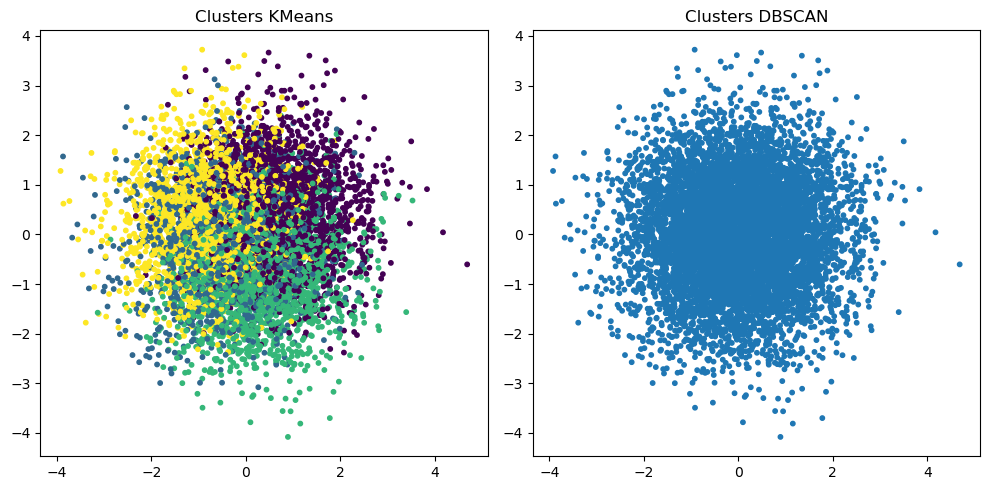

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_train['cluster_kmeans'], cmap='viridis', s=10)
plt.title("Clusters KMeans")
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_train['cluster_dbscan'], cmap='tab10', s=10)
plt.title("Clusters DBSCAN")
plt.tight_layout()
plt.show()

## 5.3. Autoencoders approach

In [18]:
X_tensor_train = torch.tensor(X_train_processed, dtype=torch.float32)
X_tensor_test = torch.tensor(X_test_processed, dtype=torch.float32)

Train/test split

In [19]:
# We create a PyTorch dataset that can be consumed by a DataLoader. TensorDataset is a way of evolving tensors
# as a simple dataset
train_data = TensorDataset(X_tensor_train)
test_data = TensorDataset(X_tensor_test)
# We create a data loader that divides the dataset in batches of 128 and shuffles the arrange randomly
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Creation of the autoencoder class

In [20]:
# nn.Module is the baseline of every model in PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int):
        # with super() we initialize the object nn.Module
        super().__init__()
        # We define the decoder that goes little by little reducing the dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), # 64 neurons for the first layer
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,32), # 32 neurons for the second layer
            nn.ReLU(),
            nn.Linear(32, 16)
            
        )
        # We define the decoder that goes little by little upgrading the dim. Reconstruction part
        self.decoder = nn.Sequential(
            nn.Linear(16, 32), 
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64,input_dim)
        )

    def forward(self, x):
        """
        Forward method that defines how the information flows. It just simply applys the encoder-decoder
        architecture.
        """
        z = self.encoder(x)
        return self.decoder(z)

In [21]:
model = Autoencoder(input_dim=X_tensor_train.shape[1])

We define the loss function as the MSE loss function

In [22]:
criterion = nn.MSELoss()

The optimizer of the model will be Adam. model.parameters() gives us access to the model weights and lr states the learning rate to consider

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
train_losses = list()
val_losses = list()

We activate the model training

In [25]:
model.train()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=94, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=94, bias=True)
  )
)

Now we go epoch by epoch training the model

In [26]:
for epoch in range(30):
    model.train()
    running_loss = 0
    for batch in train_loader:
        # we take the batch[0] because TensorDataset only has one input tensor (without target)
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # we clear the gradients
        optimizer.zero_grad()
        # we calculate the gradients
        loss.backward()
        # we update the weights
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    # We deactivate the gradient calculations (we save memory) and do the same for the test set
    with torch.no_grad():
        # same for the test set:
        for batch in test_loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

Epoch 01 | Train Loss: 0.7496 | Val Loss: 0.7172
Epoch 02 | Train Loss: 0.6968 | Val Loss: 0.6727
Epoch 03 | Train Loss: 0.6685 | Val Loss: 0.6520
Epoch 04 | Train Loss: 0.6530 | Val Loss: 0.6416
Epoch 05 | Train Loss: 0.6427 | Val Loss: 0.6322
Epoch 06 | Train Loss: 0.6363 | Val Loss: 0.6274
Epoch 07 | Train Loss: 0.6321 | Val Loss: 0.6237
Epoch 08 | Train Loss: 0.6289 | Val Loss: 0.6199
Epoch 09 | Train Loss: 0.6251 | Val Loss: 0.6161
Epoch 10 | Train Loss: 0.6197 | Val Loss: 0.6118
Epoch 11 | Train Loss: 0.6170 | Val Loss: 0.6087
Epoch 12 | Train Loss: 0.6156 | Val Loss: 0.6107
Epoch 13 | Train Loss: 0.6152 | Val Loss: 0.6073
Epoch 14 | Train Loss: 0.6132 | Val Loss: 0.6065
Epoch 15 | Train Loss: 0.6125 | Val Loss: 0.6052
Epoch 16 | Train Loss: 0.6102 | Val Loss: 0.6031
Epoch 17 | Train Loss: 0.6084 | Val Loss: 0.6010
Epoch 18 | Train Loss: 0.6056 | Val Loss: 0.5989
Epoch 19 | Train Loss: 0.6048 | Val Loss: 0.5977
Epoch 20 | Train Loss: 0.6039 | Val Loss: 0.5979
Epoch 21 | Train Los

Train and validation losses comparison

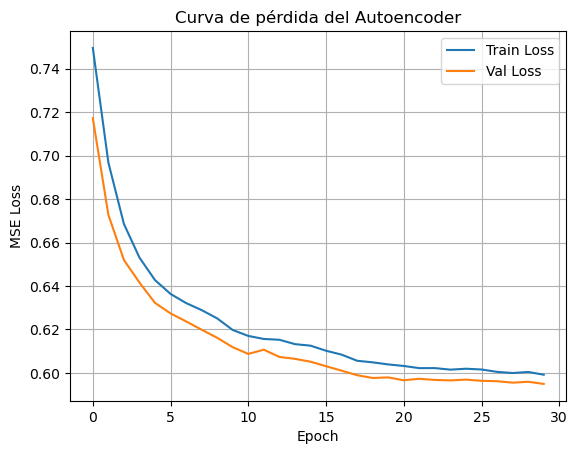

In [27]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Curva de pérdida del Autoencoder")
plt.legend()
plt.grid(True)
plt.show()

**Model evaluation**: Now we need to calculate the error of reconstruction in order to see where anomalies are

In [28]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=94, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=94, bias=True)
  )
)

We deactivate the gradient calculations (we save memory) and pass all the inputs to the model in order to get the reconstruction

In [29]:
with torch.no_grad():
    reconstructed_train = model(X_tensor_train)
    reconstructed_test = model(X_tensor_test)

We calculate the mse value by row, the bigger the error the greater the anomaly

In [30]:
mse_train = torch.mean((X_tensor_train - reconstructed_train) ** 2, dim=1)
mse_test = torch.mean((X_tensor_test - reconstructed_test) ** 2, dim=1)

In [31]:
# add the error as a column in the data frame
X_train['reconstruction_error_train'] = mse_train.numpy()
X_test['reconstruction_error_test'] = mse_test.numpy()

**anomalies detection**

In [37]:
threshold = X_train['reconstruction_error_train'].quantile(0.99)
X_train['anomaly_autoencoder'] = X_train['reconstruction_error_train'] > threshold
X_test['anomaly_autoencoder'] = X_test['reconstruction_error_test'] > threshold

X_train.rename(columns={"reconstruction_error_train": "reconstruction_error"}, inplace=True)
X_test.rename(columns={"reconstruction_error_test": "reconstruction_error"}, inplace=True)

In [38]:
df_new = pd.concat([X_train, X_test])
df_new.head()

,tipologia_cliente,tipo_consumo,ubicacion,count_eventos,num_dias_consumo_nulo,ratio_cons_dia_noche,energia_importada_semana,energia_importada_semana_anterior,energia_importada_semana_del_anio_pasado,energia_importada_mes,...,energia_reactiva_4_mes_anio_anterior,energia_reactiva_4_trimestre,energia_reactiva_4_trimestre_anterior,energia_reactiva_4_trimestre_anio_anterior,energia_reactiva_4_anio,energia_reactiva_4_anio_anterior,cluster_kmeans,cluster_dbscan,reconstruction_error,anomaly_autoencoder
9254,administración pública,energia,loc_15,2,1,1.417901,1070.401986,1278.183711,1447.571545,830.788833,...,1174.250033,1200.278570,959.497505,1260.493709,549.434970,707.242289,0.0,-1.0,0.540941,False
1561,particular,gas,loc_8,2,3,0.863170,1183.167832,1268.807815,1177.101755,773.171255,...,1116.582314,1200.797851,1068.775712,1434.660837,573.249909,422.802886,1.0,-1.0,0.641682,False
1670,particular,energia,loc_13,3,1,1.044505,1132.648161,1350.798425,1384.499871,925.890203,...,1171.469666,1137.010487,1163.874819,1522.694762,688.146557,560.944115,0.0,-1.0,0.453776,False
6087,empresa,gas,loc_19,2,0,1.034424,1188.059848,1187.582070,1440.940343,801.557225,...,1283.655467,927.790497,1187.774562,1213.229883,674.527449,456.539806,3.0,-1.0,0.560334,False
6669,empresa,energia,loc_10,3,1,1.098879,1164.286492,1196.470200,1099.359965,1018.299981,...,1092.139494,988.257771,934.771751,1388.818988,707.629363,600.651025,3.0,-1.0,0.485451,False
